In [105]:
import torch
import torch.nn as nn

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

tensor([[ 2.7017, -0.4444],
        [ 7.3516,  8.7878],
        [ 1.7707,  1.2210],
        [ 8.3679, 11.8708],
        [-0.5860, -5.3500]]) tensor([2., 3., 2., 3., 1.])


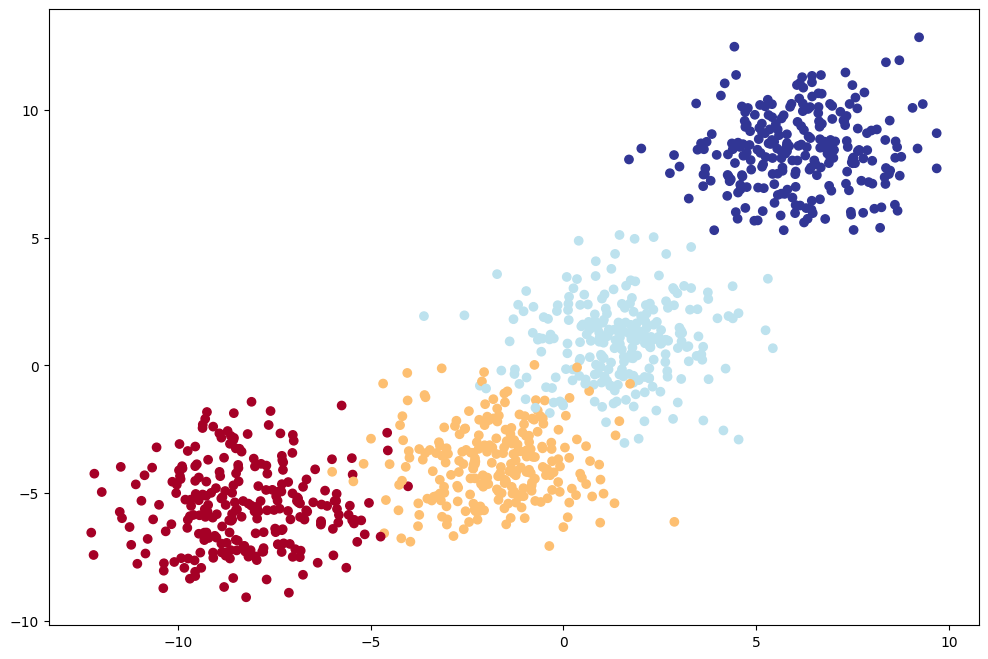

In [106]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 57

X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)
print(X_blob[:5], y_blob[:5])


X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(12,8))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [108]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features= hidden_units),
            nn.Linear(in_features= hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features= output_features)

        )

    def forward(self, X:torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(X)

In [109]:
model_0 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES, 
    hidden_units=8).to(device)

model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [110]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.03)

In [111]:
model_0(X_blob_train.to(device))[:5]

tensor([[-1.6466,  1.1922, -0.0640, -2.1875],
        [ 1.0254, -1.0102, -0.6705,  2.0158],
        [-0.5737,  0.7577, -0.2198, -0.3999],
        [-0.0805,  0.7407, -0.2558,  0.4626],
        [-0.7348,  1.1037, -0.1416, -0.6059]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [112]:
model_0(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [113]:
y_logits = model_0(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.2866, -1.4251, -0.7687,  2.3824],
        [-0.3173,  0.3117, -0.3238, -0.0487],
        [ 0.6234, -0.4042, -0.5257,  1.4444],
        [ 1.2401, -1.4323, -0.7670,  2.2991],
        [ 0.1839,  0.3188, -0.3555,  0.8333]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2389, 0.0159, 0.0306, 0.7147],
        [0.1931, 0.3623, 0.1919, 0.2527],
        [0.2533, 0.0907, 0.0803, 0.5757],
        [0.2447, 0.0169, 0.0329, 0.7055],
        [0.2154, 0.2466, 0.1256, 0.4124]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [114]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [115]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2389, 0.0159, 0.0306, 0.7147], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [116]:
from helper_functions import accuracy_fn

torch.manual_seed(57)

epochs = 200

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train = y_blob_train.type(torch.LongTensor).to(device)
y_blob_test = y_blob_test.type(torch.LongTensor).to(device)


for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 2.30858, Acc: 2.12% | Test Loss: 1.47080, Test Acc: 35.50%
Epoch: 10 | Loss: 0.71887, Acc: 72.50% | Test Loss: 0.74578, Test Acc: 69.50%
Epoch: 20 | Loss: 0.61014, Acc: 72.62% | Test Loss: 0.64721, Test Acc: 69.50%
Epoch: 30 | Loss: 0.54806, Acc: 72.75% | Test Loss: 0.58398, Test Acc: 70.00%
Epoch: 40 | Loss: 0.49908, Acc: 72.88% | Test Loss: 0.53321, Test Acc: 71.50%
Epoch: 50 | Loss: 0.45749, Acc: 77.38% | Test Loss: 0.49015, Test Acc: 74.00%
Epoch: 60 | Loss: 0.42146, Acc: 82.50% | Test Loss: 0.45301, Test Acc: 78.00%
Epoch: 70 | Loss: 0.39014, Acc: 86.25% | Test Loss: 0.42088, Test Acc: 84.00%
Epoch: 80 | Loss: 0.36297, Acc: 88.88% | Test Loss: 0.39308, Test Acc: 86.00%
Epoch: 90 | Loss: 0.33940, Acc: 90.00% | Test Loss: 0.36899, Test Acc: 87.00%
Epoch: 100 | Loss: 0.31887, Acc: 90.62% | Test Loss: 0.34799, Test Acc: 89.00%
Epoch: 110 | Loss: 0.30085, Acc: 91.38% | Test Loss: 0.32951, Test Acc: 89.50%
Epoch: 120 | Loss: 0.28487, Acc: 92.12% | Test Loss: 0.31307, Te

In [117]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_blob_test)

y_logits[:10]

tensor([[ 11.8309,   7.6824,  -4.8310, -10.5548],
        [ -1.3601,  -0.2604,   1.0633,  -0.3157],
        [  5.2260,   5.5573,  -1.5013,  -7.0521],
        [ 11.6673,   7.2319,  -4.8298, -10.1191],
        [  0.6722,   4.3280,   0.8426,  -4.8440],
        [  6.6925,   6.5310,  -2.1380,  -8.2699],
        [-15.8746,  -7.7895,   7.7962,   9.8890],
        [ -4.0665,  -1.2251,   2.4084,   1.2018],
        [-15.6354, -10.1282,   7.1821,  11.8806],
        [  1.8224,   3.7745,   0.0741,  -4.6440]], device='cuda:0')

In [118]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_pred = y_pred_probs.argmax(dim=1)


print(f"Predictions: {y_pred[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_pred)}%")

Predictions: tensor([0, 2, 1, 0, 1, 0, 3, 2, 3, 1], device='cuda:0')
Labels: tensor([0, 2, 1, 0, 1, 0, 3, 2, 3, 1], device='cuda:0')
Test accuracy: 93.0%


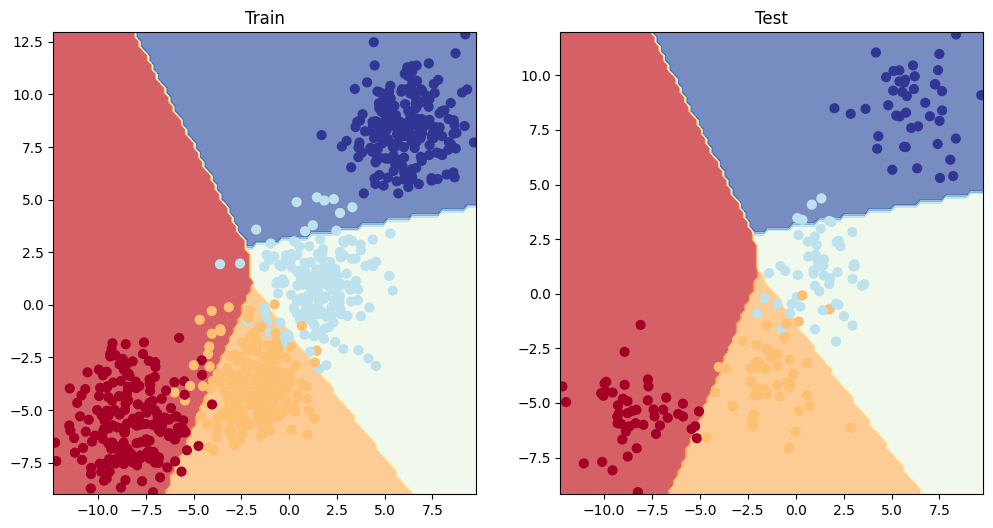

In [120]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)

In [123]:
try:
    from torchmetrics import Accuracy
except:
    %pip install torchmetrics
    from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetrics_accuracy(y_pred, y_blob_test)


tensor(0.9300, device='cuda:0')